## Aditya Jindal
## Batch M6
## Assignment 6B
## _Different type of Convolutions_

In [0]:
# Importing all the required libraries from the modules

from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D, DepthwiseConv2D
from keras.layers import Activation, Flatten, Dense, Dropout, Concatenate
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import *
from keras.utils import np_utils

In [0]:
# Loading a database and getting unique number of classes
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

print(num_classes)
print(train_features.shape)
print(test_features.shape)

10
(50000, 32, 32, 3)
(10000, 32, 32, 3)


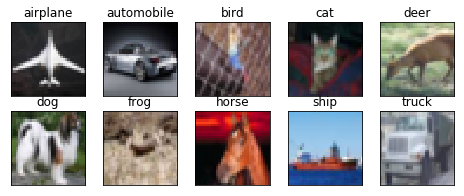

In [0]:
# Printing mentioned classes samples
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
# Defining function to plot loss and accuracy for model
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
# Function to get accuracy on our test data
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
# Set/Convert all the pixel values to float data type 
# Normalizing all pixel values by dividing with 255 so that every value lies btw 0-1

train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255

# Converted the above 1-dimensional class label arrays to num_classes-dimensional class matrices
# As the test and train labels are not splitted into num_classes distinct labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
# Defining a model using Functional API of Keras
# Import library for functional API
from keras.models import Model
from keras.layers import Input
from keras.regularizers import l2

# Declaring regulariser value
kernel_l2 = 1e-5

input = Input(shape=(32,32,3))

#Normal Conv
ConvL1 = Conv2D(32,(3, 3), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(input)
BNL1 = BatchNormalization()(ConvL1)
DL1 = Dropout(0.1)(BNL1)

#Seperable Conv
SConvL12 = Conv2D(64,(3, 1), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(DL1)
SBNL12 = BatchNormalization()(SConvL12)

SConvL22 = Conv2D(64,(1, 3), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(SBNL12)
SBNL22 = BatchNormalization()(SConvL22)
DL2 = Dropout(0.1)(SBNL22)

MPL1 = MaxPooling2D(pool_size=(2, 2))(DL2)

ConvPoint1 = Conv2D(32,(1, 1), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(MPL1)

#DepthWise Conv
ConvL5 = DepthwiseConv2D(64,(3, 3), activation='relu', depthwise_regularizer=l2(kernel_l2), padding='same')(ConvPoint1)
BNL5 = BatchNormalization()(ConvL5)
DL5 = Dropout(0.1)(BNL5)

# Grouped Convs
GConvL1 = Conv2D(64,(3, 3), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(DL5)
GBNL1 = BatchNormalization()(GConvL1)
GDL1 = Dropout(0.1)(GBNL1)

GConvL2 = Conv2D(64,(5, 5), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(DL5)
GBNL2 = BatchNormalization()(GConvL2)
GDL2 = Dropout(0.1)(GBNL2)

Concat_1 = Concatenate(axis=-1)([GDL1, GDL2, DL5])

MPL2 = MaxPooling2D(pool_size=(2, 2))(Concat_1)

ConvPoint2 = Conv2D(32,(1, 1), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(MPL2)

# Grouped Convs with dialation
GConvL3 = Conv2D(64,(3, 3), activation='relu', dilation_rate=(1, 1), kernel_regularizer=l2(kernel_l2), padding='same')(ConvPoint2)
GBNL3 = BatchNormalization()(GConvL3)
GDL3 = Dropout(0.1)(GBNL3)

GConvL4 = Conv2D(64,(3, 3), activation='relu', dilation_rate=(2, 2), kernel_regularizer=l2(kernel_l2), padding='same')(ConvPoint2)
GBNL4 = BatchNormalization()(GConvL4)
GDL4 = Dropout(0.1)(GBNL4)

Concat_2 = Concatenate(axis=-1)([GDL3, GDL4, MPL2])

ConvOut = Conv2D(num_classes,(3, 3), kernel_regularizer=l2(kernel_l2))(Concat_2)

F_layer = Flatten()(ConvOut)

output = Activation('softmax')(F_layer)

#Initialising the Model
model_tuned = Model(inputs=[input], outputs=[output])
model_tuned.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 32, 32, 32)   896         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 32, 32, 32)   128         conv2d_24[0][0]                  
__________________________________________________________________________________________________
dropout_17 (Dropout)            (None, 32, 32, 32)   0           batch_normalization_20[0][0]     
__________________________________________________________________________________________________
conv2d_25 

In [0]:
# Compile the model
model_tuned.compile(optimizer=Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Changing Learning rate based on monitored quantity
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=4, verbose=1, 
             mode='max', min_delta=0.001, min_lr=0.0001)


Epoch 1/50
390/390 [==============================] - 19s 50ms/step - loss: 2.2223 - acc: 0.3623 - val_loss: 4.9869 - val_acc: 0.2987
Epoch 2/50
390/390 [==============================] - 17s 42ms/step - loss: 1.6425 - acc: 0.4825 - val_loss: 2.1355 - val_acc: 0.3114
Epoch 3/50
390/390 [==============================] - 17s 42ms/step - loss: 1.3049 - acc: 0.5522 - val_loss: 1.8065 - val_acc: 0.4157
Epoch 4/50
390/390 [==============================] - 16s 42ms/step - loss: 1.2024 - acc: 0.5826 - val_loss: 1.1910 - val_acc: 0.5899
Epoch 5/50
390/390 [==============================] - 16s 41ms/step - loss: 1.1579 - acc: 0.5987 - val_loss: 1.2286 - val_acc: 0.5903
Epoch 6/50
390/390 [==============================] - 16s 42ms/step - loss: 1.0800 - acc: 0.6300 - val_loss: 1.1389 - val_acc: 0.6051
Epoch 7/50
390/390 [==============================] - 16s 42ms/step - loss: 1.0375 - acc: 0.6461 - val_loss: 1.3180 - val_acc: 0.5563
Epoch 8/50
390/390 [==============================] - 17s 43ms

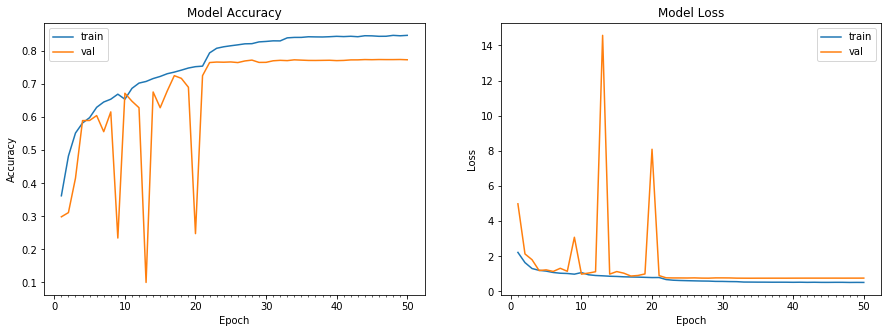

Accuracy on test data is: 77.40 


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info_tuned = model_tuned.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 steps_per_epoch = train_features.shape[0]//128, epochs = 50, 
                                 validation_data = (test_features, test_labels), verbose=1, callbacks = [reduce_lr])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info_tuned)
# compute test accuracy
print ("Accuracy on test data is: %0.2f "%accuracy(test_features, test_labels, model_tuned))

## Train Accuracy
### Achieved 84.79 at the 50th epoch
### Max achieved 84.79 at the 50th epoch

